# <font color="green"> Data Analytics + Model Training for the SQL Analytics problem 
    

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# To link pandas dataframe to plotly which allows to use .iplot 
import cufflinks as cf 
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy.random as nr
import sklearn.model_selection as ms
from sklearn import preprocessing
from sklearn import linear_model
import sklearn.metrics as sklm
import math

# Data Preparation

## <font color="red">Exploring the data

In [2]:
# Reading data
with open("slow_log.json") as f:
    raw_data = json.load(f) 

In [3]:
# raw data to pandas datarframe

df = pd.DataFrame(raw_data)

In [4]:
df.head()

,start_time,user_host,query_time,lock_time,rows_sent,rows_examined,db,last_insert_id,insert_id,server_id,sql_text,thread_id
0,2021-01-14 15:11:51.815988,guest[guest] @ [185.9.209.177],00:00:00.000093,00:00:00,0,0,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,67
1,2021-01-14 15:11:51.749969,guest[guest] @ [185.9.209.177],00:00:00.000055,00:00:00,0,0,tpch,0,0,97408076,SHOW WARNINGS,67
2,2021-01-14 15:11:51.687122,guest[guest] @ [185.9.209.177],00:00:00.000076,00:00:00,0,0,tpch,0,0,97408076,SHOW WARNINGS,67
3,2021-01-14 15:11:51.623647,guest[guest] @ [185.9.209.177],00:00:00.000138,00:00:00,1,1,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ select...,67
4,2021-01-14 15:11:51.562513,guest[guest] @ [185.9.209.177],00:00:00.000090,00:00:00,0,0,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,67


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15688 entries, 0 to 15687
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   start_time      15688 non-null  object
 1   user_host       15688 non-null  object
 2   query_time      15688 non-null  object
 3   lock_time       15688 non-null  object
 4   rows_sent       15688 non-null  int64 
 5   rows_examined   15688 non-null  int64 
 6   db              15688 non-null  object
 7   last_insert_id  15688 non-null  int64 
 8   insert_id       15688 non-null  int64 
 9   server_id       15688 non-null  int64 
 10  sql_text        15688 non-null  object
 11  thread_id       15688 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.4+ MB


### Any null value? 

In [6]:
df.isnull().values.any()

False

### Frequency table

In [7]:
def count_unique(dataframe, cols): 
    for col in cols:
        print("\n"+"For column "+ col)
        print(dataframe[col].value_counts())
cat_cols = ["user_host","db", "thread_id"]
count_unique(df, cat_cols)


For column user_host
rdsadmin[rdsadmin] @ localhost [127.0.0.1]    9160
guest[guest] @  [172.31.36.183]               6313
guest[guest] @  [185.9.209.177]                127
rdsadmin[rdsadmin] @ localhost []               88
Name: user_host, dtype: int64

For column db
        9248
tpch    6440
Name: db, dtype: int64

For column thread_id
9     9160
20    3155
40    3154
67      52
63      48
23      24
19       4
14       3
18       2
27       2
66       2
58       2
50       2
42       2
34       2
26       2
57       2
65       2
43       2
49       2
41       2
33       2
25       2
64       2
56       2
48       2
32       2
35       2
59       2
51       2
61       2
47       2
39       2
31       2
62       2
54       2
46       2
38       2
30       2
22       2
53       2
55       2
45       2
37       2
29       2
21       2
60       2
52       2
44       2
36       2
28       2
24       2
Name: thread_id, dtype: int64


### Features with non-unique elements

In [8]:
col_non_unique = [] 
for i in df.columns: 
    if np.shape(df[i].unique())[0] != 1: 
        col_non_unique.append(i)
    else: 
        pass

print("The following columns have non unique elements: ")
print(col_non_unique)
    

The following columns have non unique elements: 
['start_time', 'user_host', 'query_time', 'lock_time', 'rows_sent', 'rows_examined', 'db', 'sql_text', 'thread_id']


## Cleaning the dataframe, Feature engineering and transforming variables

#### Steps: 
#### 1- Creating a df with appropriate columns for further analysis ('sql_text', 'query_time', 'start_time',  'rows_sent', 'rows_examined', 'thread_id', 'query_time' )
#### 2- Recoding the temporal columns and convert them to float numbers 
#### 3- Digitizing sql_text column 
#### 4- Creating a new column with the difference of 'rows_sent' and 'rows_examined' (which is an important parameter to determine the query execution time)

In [9]:
# Create a new dataframe

df_clean = df[["sql_text", 'start_time','rows_sent'
               , 'rows_examined', 'thread_id'
               ,'lock_time','query_time']]

In [10]:
df_clean.head()

,sql_text,start_time,rows_sent,rows_examined,thread_id,lock_time,query_time
0,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,2021-01-14 15:11:51.815988,0,0,67,00:00:00,00:00:00.000093
1,SHOW WARNINGS,2021-01-14 15:11:51.749969,0,0,67,00:00:00,00:00:00.000055
2,SHOW WARNINGS,2021-01-14 15:11:51.687122,0,0,67,00:00:00,00:00:00.000076
3,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-01-14 15:11:51.623647,1,1,67,00:00:00,00:00:00.000138
4,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,2021-01-14 15:11:51.562513,0,0,67,00:00:00,00:00:00.000090


### Recode temporal columns

In [11]:
# converting query_time to float 
# query times are different from the second digit so we select 
# them and store them in the cleaned dataframe
qtime_s = []
for i in list(df_clean["query_time"]):
    d_s = datetime.strptime(i, "%H:%M:%S.%f").strftime('%S.%f')
    qtime_s.append(float(d_s))

df_clean.insert(6, 'query_time_milisec',np.array(qtime_s)*1e3, True)  

In [12]:
df_clean = df_clean.drop(columns=["query_time"]) # Drop the original query time

In [13]:
df_clean.head()

,sql_text,start_time,rows_sent,rows_examined,thread_id,lock_time,query_time_milisec
0,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,2021-01-14 15:11:51.815988,0,0,67,00:00:00,0.093
1,SHOW WARNINGS,2021-01-14 15:11:51.749969,0,0,67,00:00:00,0.055
2,SHOW WARNINGS,2021-01-14 15:11:51.687122,0,0,67,00:00:00,0.076
3,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-01-14 15:11:51.623647,1,1,67,00:00:00,0.138
4,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,2021-01-14 15:11:51.562513,0,0,67,00:00:00,0.090


#### The lock_time feature seems to be a relevant feature for estimating the query execution time. We will clean it up and will see if it is useful or not later. 

lock_time is the time spend before the query starts executing. i.e., time waiting for other threads to give up their locks on the data the current query needs to lock.

In [14]:
# converting lock_time to float 
lock_t = []
for i in list(df_clean["lock_time"]):
    if i == '00:00:00': 
        lock_t.append(0.0)
    else: 
        d = datetime.strptime(i, "%H:%M:%S.%f").strftime('%S.%f')
        d_in_ms = float(d)
        lock_t.append(d_in_ms)
        
df_clean.insert(6, 'lock_time_milisec',np.array(lock_t)*1e3, True)  
df_clean = df_clean.drop(columns=["lock_time"])
df_clean.head()

,sql_text,start_time,rows_sent,rows_examined,thread_id,lock_time_milisec,query_time_milisec
0,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,2021-01-14 15:11:51.815988,0,0,67,0.0,0.093
1,SHOW WARNINGS,2021-01-14 15:11:51.749969,0,0,67,0.0,0.055
2,SHOW WARNINGS,2021-01-14 15:11:51.687122,0,0,67,0.0,0.076
3,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-01-14 15:11:51.623647,1,1,67,0.0,0.138
4,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,2021-01-14 15:11:51.562513,0,0,67,0.0,0.090


### We can use the "rows_examined" and "rows_sent" columns and recode them to a new feature which is believed to be very important when dealing with query optimization. 

queries for which rows_examined is by far larger than rows_sent, then the query is a great candidate for optimization (Ref: percona.com/blog/2014/02/28/rows_sent-can-rows_examined/)

In [15]:
# If rows_examined is by far larger than rows_sent,
#then the query is a great candidate for optimization

# Create a new column as the differnce of rows_sent and rows_examined 


row_diff = df_clean["rows_examined"].values-df_clean["rows_sent"].values
df_clean.insert(5,'row_diff',row_diff, True) 
df_clean = df_clean.drop(columns=["rows_examined", "rows_sent"])
df_clean.head()

,sql_text,start_time,thread_id,row_diff,lock_time_milisec,query_time_milisec
0,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,2021-01-14 15:11:51.815988,67,0,0.0,0.093
1,SHOW WARNINGS,2021-01-14 15:11:51.749969,67,0,0.0,0.055
2,SHOW WARNINGS,2021-01-14 15:11:51.687122,67,0,0.0,0.076
3,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-01-14 15:11:51.623647,67,0,0.0,0.138
4,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,2021-01-14 15:11:51.562513,67,0,0.0,0.090


### Data Statistics 

In [16]:
df_stat = df_clean.describe()
df_stat

,thread_id,row_diff,lock_time_milisec,query_time_milisec
count,15688.000000,1.568800e+04,15688.000000,15688.000000
mean,18.017848,6.007734e+05,0.155016,546.454841
std,12.811516,1.245758e+06,0.931420,1211.287087
min,9.000000,-1.000000e+00,0.000000,0.007000
25%,9.000000,0.000000e+00,0.000000,0.442000
50%,9.000000,0.000000e+00,0.072000,1.310500
75%,20.000000,3.415910e+05,0.177000,539.295000
max,67.000000,4.501837e+06,71.033000,11073.425000


### Creating two new categorical features using the query_time_millisec and the row_diff columns. 
These will be useful in data visualization. 

In [17]:
query_time_bin = [] 
for i in range(len(df_clean)): 
    if df_clean["query_time_milisec"][i]<=df_stat["query_time_milisec"][4]: 
        query_time_bin.append("First quartile")
    elif df_clean["query_time_milisec"][i]>df_stat["query_time_milisec"][4] and df_clean["query_time_milisec"][i]<=df_stat["query_time_milisec"][5]: 
        query_time_bin.append("Secound Quartile")
    elif df_clean["query_time_milisec"][i]>df_stat["query_time_milisec"][5] and df_clean["query_time_milisec"][i]<=df_stat["query_time_milisec"][6]: 
        query_time_bin.append("Third Quartile")
    else: 
        query_time_bin.append("Fourth Quartile")

df_clean.insert(6, 'query_time_bin',query_time_bin, True)  
df_clean.head()

,sql_text,start_time,thread_id,row_diff,lock_time_milisec,query_time_milisec,query_time_bin
0,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,2021-01-14 15:11:51.815988,67,0,0.0,0.093,First quartile
1,SHOW WARNINGS,2021-01-14 15:11:51.749969,67,0,0.0,0.055,First quartile
2,SHOW WARNINGS,2021-01-14 15:11:51.687122,67,0,0.0,0.076,First quartile
3,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-01-14 15:11:51.623647,67,0,0.0,0.138,First quartile
4,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,2021-01-14 15:11:51.562513,67,0,0.0,0.090,First quartile


In [18]:
row_diff_bin = [] 
for i in range(len(df_clean)): 
    if df_clean["row_diff"][i]<=df_stat["row_diff"][4]: 
        row_diff_bin.append("First quartile")
    elif df_clean["row_diff"][i]>df_stat["row_diff"][4] and df_clean["row_diff"][i]<=df_stat["row_diff"][5]: 
        row_diff_bin.append("Secound Quartile")
    elif df_clean["row_diff"][i]>df_stat["row_diff"][5] and df_clean["row_diff"][i]<=df_stat["row_diff"][6]: 
        row_diff_bin.append("Third Quartile")
    else: 
        row_diff_bin.append("Fourth Quartile")

df_clean.insert(6, 'row_diff_bin',row_diff_bin, True)  
df_clean.head()

,sql_text,start_time,thread_id,row_diff,lock_time_milisec,query_time_milisec,row_diff_bin,query_time_bin
0,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,2021-01-14 15:11:51.815988,67,0,0.0,0.093,First quartile,First quartile
1,SHOW WARNINGS,2021-01-14 15:11:51.749969,67,0,0.0,0.055,First quartile,First quartile
2,SHOW WARNINGS,2021-01-14 15:11:51.687122,67,0,0.0,0.076,First quartile,First quartile
3,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-01-14 15:11:51.623647,67,0,0.0,0.138,First quartile,First quartile
4,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,2021-01-14 15:11:51.562513,67,0,0.0,0.090,First quartile,First quartile


## Extracting useful information from the sql_text column:

In [19]:
# Length of the query text 
df_clean['sql_len'] = df_clean['sql_text'].astype(str).apply(len)

In [20]:
# Number of words in query text  
df_clean['sql_word_count'] = df_clean['sql_text'].apply(lambda x: len(str(x).split()))

In [21]:
df_stat = df_clean.describe()
df_stat

,thread_id,row_diff,lock_time_milisec,query_time_milisec,sql_len,sql_word_count
count,15688.000000,1.568800e+04,15688.000000,15688.000000,15688.000000,15688.000000
mean,18.017848,6.007734e+05,0.155016,546.454841,199.146673,26.291178
std,12.811516,1.245758e+06,0.931420,1211.287087,241.047115,33.325687
min,9.000000,-1.000000e+00,0.000000,0.007000,4.000000,1.000000
25%,9.000000,0.000000e+00,0.000000,0.442000,8.000000,2.000000
50%,9.000000,0.000000e+00,0.072000,1.310500,68.000000,6.000000
75%,20.000000,3.415910e+05,0.177000,539.295000,326.000000,43.000000
max,67.000000,4.501837e+06,71.033000,11073.425000,1557.000000,157.000000


### For many of these columns, such as sql_len and the label value, query_time_milisec, there is a significant difference between the mean and the median values. When the median value is less than the mean, this indicates that the distribution is right-skewed, that is, with a tail stretching toward the right. 

## <font color="red"> Visualizing the Data 

### Kernel density plots

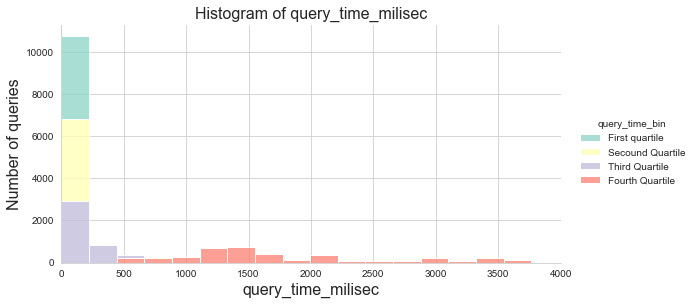

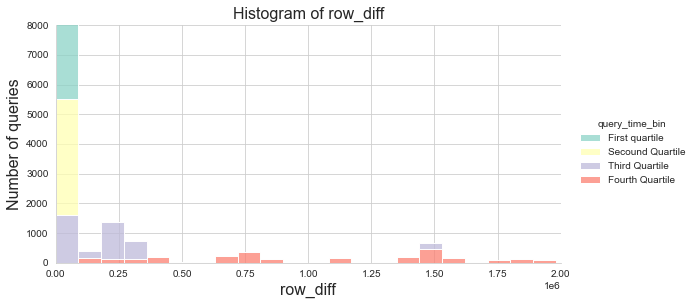

In [22]:
def plot_density(dataframe, col, bins = 50, hue= "query_time_bin", x_lim=[0,4], y_lim=[None, None]):
    sns.set_style("whitegrid")
    #sns.distplot(auto_prices[col], bins = bins, rug=True, hist = hist)
    sns.displot(dataframe, x=col, palette="Set3", hue=hue
                , multiple="stack", height=4, aspect=2, bins=bins)
    plt.title('Histogram of ' + col, fontsize=16) # Give the plot a main title
    plt.xlabel(col, fontsize=16) # Set text for the x axis
    plt.ylabel('Number of queries',fontsize=16)# Set text for y axis
    plt.xlim(x_lim[0], x_lim[1])
    plt.ylim(y_lim[0], y_lim[1])
    plt.show()
num_cols = ["query_time_milisec", "row_diff"]
xlims = [[0,4000], [0,2e6]]
ylims = [[0,None], [0,8000]]
for i in range(len(num_cols)): 
    plot_density(df_clean, num_cols[i], x_lim= xlims[i], y_lim=ylims[i])   

### Most of the queries with high vaue of row_diff are the ones belonging to the Fourth quartile of the query execution time bin. i.e. they take longer to execute. It seems that there is a correlation between these two parameters. 

### Scatter plots

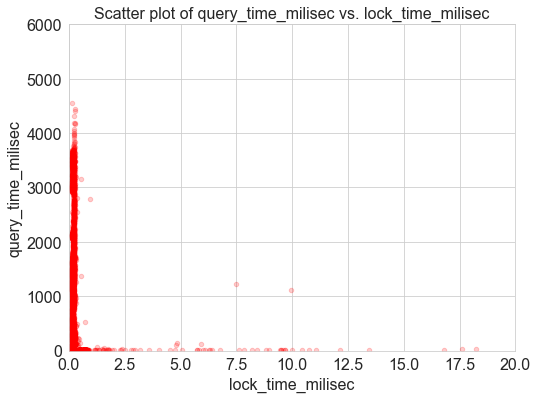

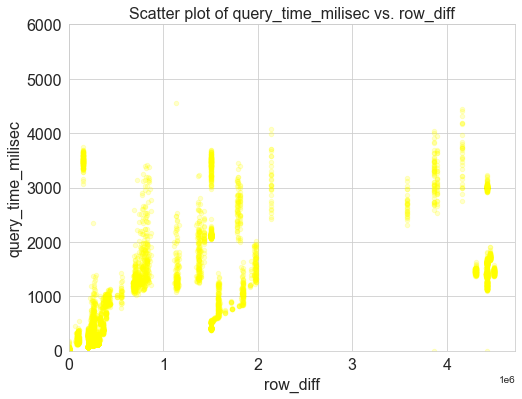

In [23]:
def plot_scatter(dataframe, col, col_y = 'query_time_milisec', x_lim=[0,4], y_lim=[None, None], cl= "blue", alpha = 1.0):
    fig = plt.figure(figsize=(8,6))
    ax = fig.gca()
    dataframe.plot.scatter(x = col, y = col_y, ax = ax, color=cl, alpha=alpha)
    ax.set_title('Scatter plot of ' + col_y + ' vs. ' + col, fontsize=16)
    ax.set_xlabel(col,fontsize=16)
    ax.set_ylabel(col_y, fontsize=16)
    ax.set_xlim(x_lim[0], x_lim[1])
    ax.set_ylim(y_lim[0], y_lim[1])
    ax.tick_params(axis='both',labelsize=16)
    plt.show()
cols=["lock_time_milisec", "row_diff"]
xlims = [[0, 20], [0, None]]
ylims = [[0, 6000], [0, 6000]]
color = ["red", "yellow"]
for i in range(len(cols)):
    plot_scatter(df_clean, col=cols[i], x_lim= xlims[i], y_lim=ylims[i], cl = color[i], alpha=0.2)

##### There is a nice linear relation between the query time and row_diff which means it's an important feature when applying LM models.  

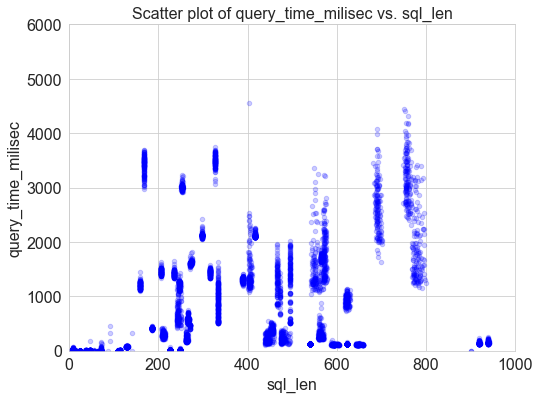

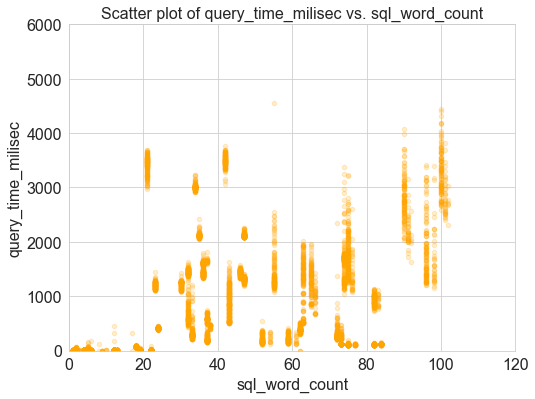

In [24]:
cols=['sql_len', 'sql_word_count']
xlims = [[0, 1000], [0, 120]]
ylims = [[0, 6000], [0, 6000]]
color = ["blue", "orange"]
for i in range(len(cols)):
    plot_scatter(df_clean, col=cols[i], x_lim= xlims[i], y_lim=ylims[i], cl = color[i], alpha=0.2)


#### There is a linear relation between the query time and the sql word count and length as well! So they are useful features. 

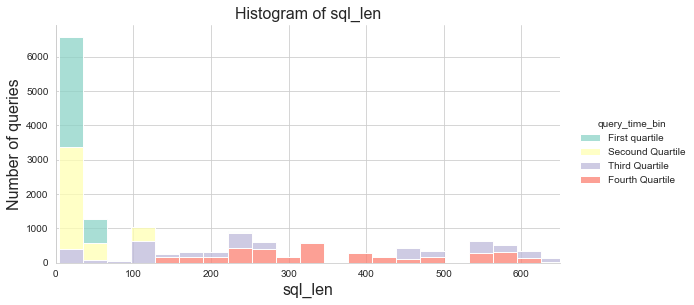

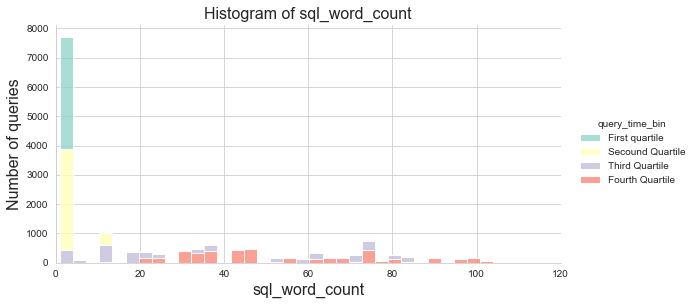

In [25]:
# Distribution of sql_len and sql_word_count

num_cols = ["sql_len", "sql_word_count"]
xlims = [[0,650], [0,120]]
ylims = [[0,None], [0,None]]
for i in range(len(num_cols)): 
    plot_density(df_clean, num_cols[i], x_lim= xlims[i], y_lim=ylims[i])   

#### From the distritution plots, we conclude that the queries with longer length and more words are mainly in the third and fourth quartile of the query time.  

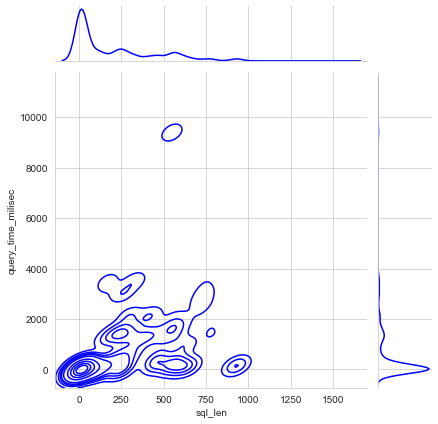

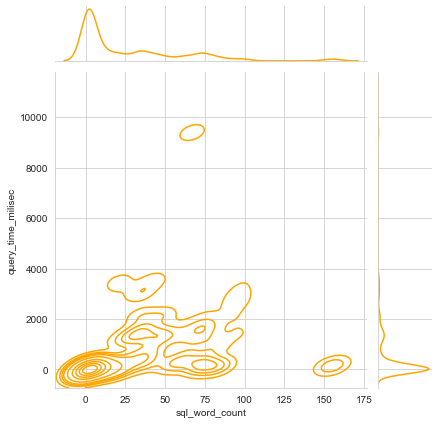

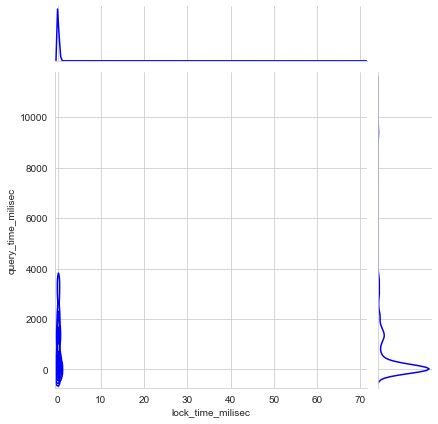

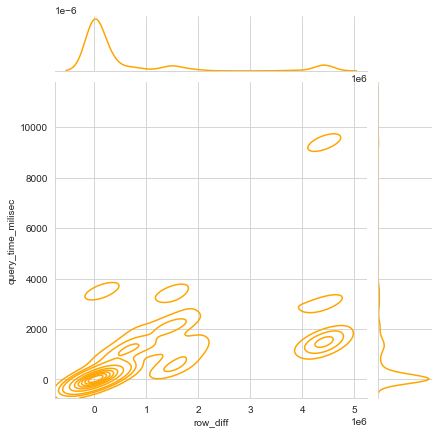

In [26]:
def plot_density_2d(dataframe, cols, col_y = 'query_time_milisec', kind="kde", color="yellow"):
    sns.set_style("whitegrid")
    sns.jointplot(cols, col_y, data=dataframe, kind=kind, color=color, height=6)
    plt.xlabel(cols, fontsize=20) 
    plt.ylabel(col_y, fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.show()
   
    
cols=["sql_len", "sql_word_count", "lock_time_milisec", "row_diff"]
color = ["blue", "orange", "blue", "orange"]
for i in range(len(cols)):
    plot_density_2d(df_clean, cols[i], color=color[i])  
 

## <font color="red"> Model training
    

This dataset contains sql_text column which is an important feature to predict the query execution time. One can treat this problem as a Machine Learning problem, from the Natural Language Processing (NLP) kind. So we need preprocess the sql_txt column before training ML models. 

###  Preprocessing Natural Language

In [27]:
import re
def query_tokenize(sql_str):
    # remove the /* */ comments
    q = re.sub(r"/\*[^*]*\*+(?:[^*/][^*]*\*+)*/", "", sql_str)

    # remove whole line -- and # comments
    lines = [line for line in q.splitlines() if not re.match("^\s*(--|#)", line)]

    # split on blanks, parens and semicolons
    tokens = re.split(r"[\s)(;]+", q)
  
    return tokens

In [28]:
sql_txt_tokenized = []
for i in range(len(df_clean)): 
    sql_txt_tokenized.append(' '.join([str(elem) for elem in query_tokenize(df_clean["sql_text"][i])]))   


In [29]:
df_clean.insert(3, 'sql_text_tokenized',sql_txt_tokenized, True)  
df_clean.head()

,sql_text,start_time,thread_id,sql_text_tokenized,row_diff,lock_time_milisec,query_time_milisec,row_diff_bin,query_time_bin,sql_len,sql_word_count
0,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,2021-01-14 15:11:51.815988,67,SET net_write_timeout=600,0,0.0,0.093,First quartile,First quartile,65,6
1,SHOW WARNINGS,2021-01-14 15:11:51.749969,67,SHOW WARNINGS,0,0.0,0.055,First quartile,First quartile,13,2
2,SHOW WARNINGS,2021-01-14 15:11:51.687122,67,SHOW WARNINGS,0,0.0,0.076,First quartile,First quartile,13,2
3,/* ApplicationName=DataGrip 2020.2.3 */ select...,2021-01-14 15:11:51.623647,67,select database,0,0.0,0.138,First quartile,First quartile,57,6
4,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,2021-01-14 15:11:51.562513,67,SET SQL_SELECT_LIMIT=DEFAULT,0,0.0,0.090,First quartile,First quartile,68,6


### WordClouds  plot for the query text column 

There are 2858705 words in the combination of all cells in column sql_text.


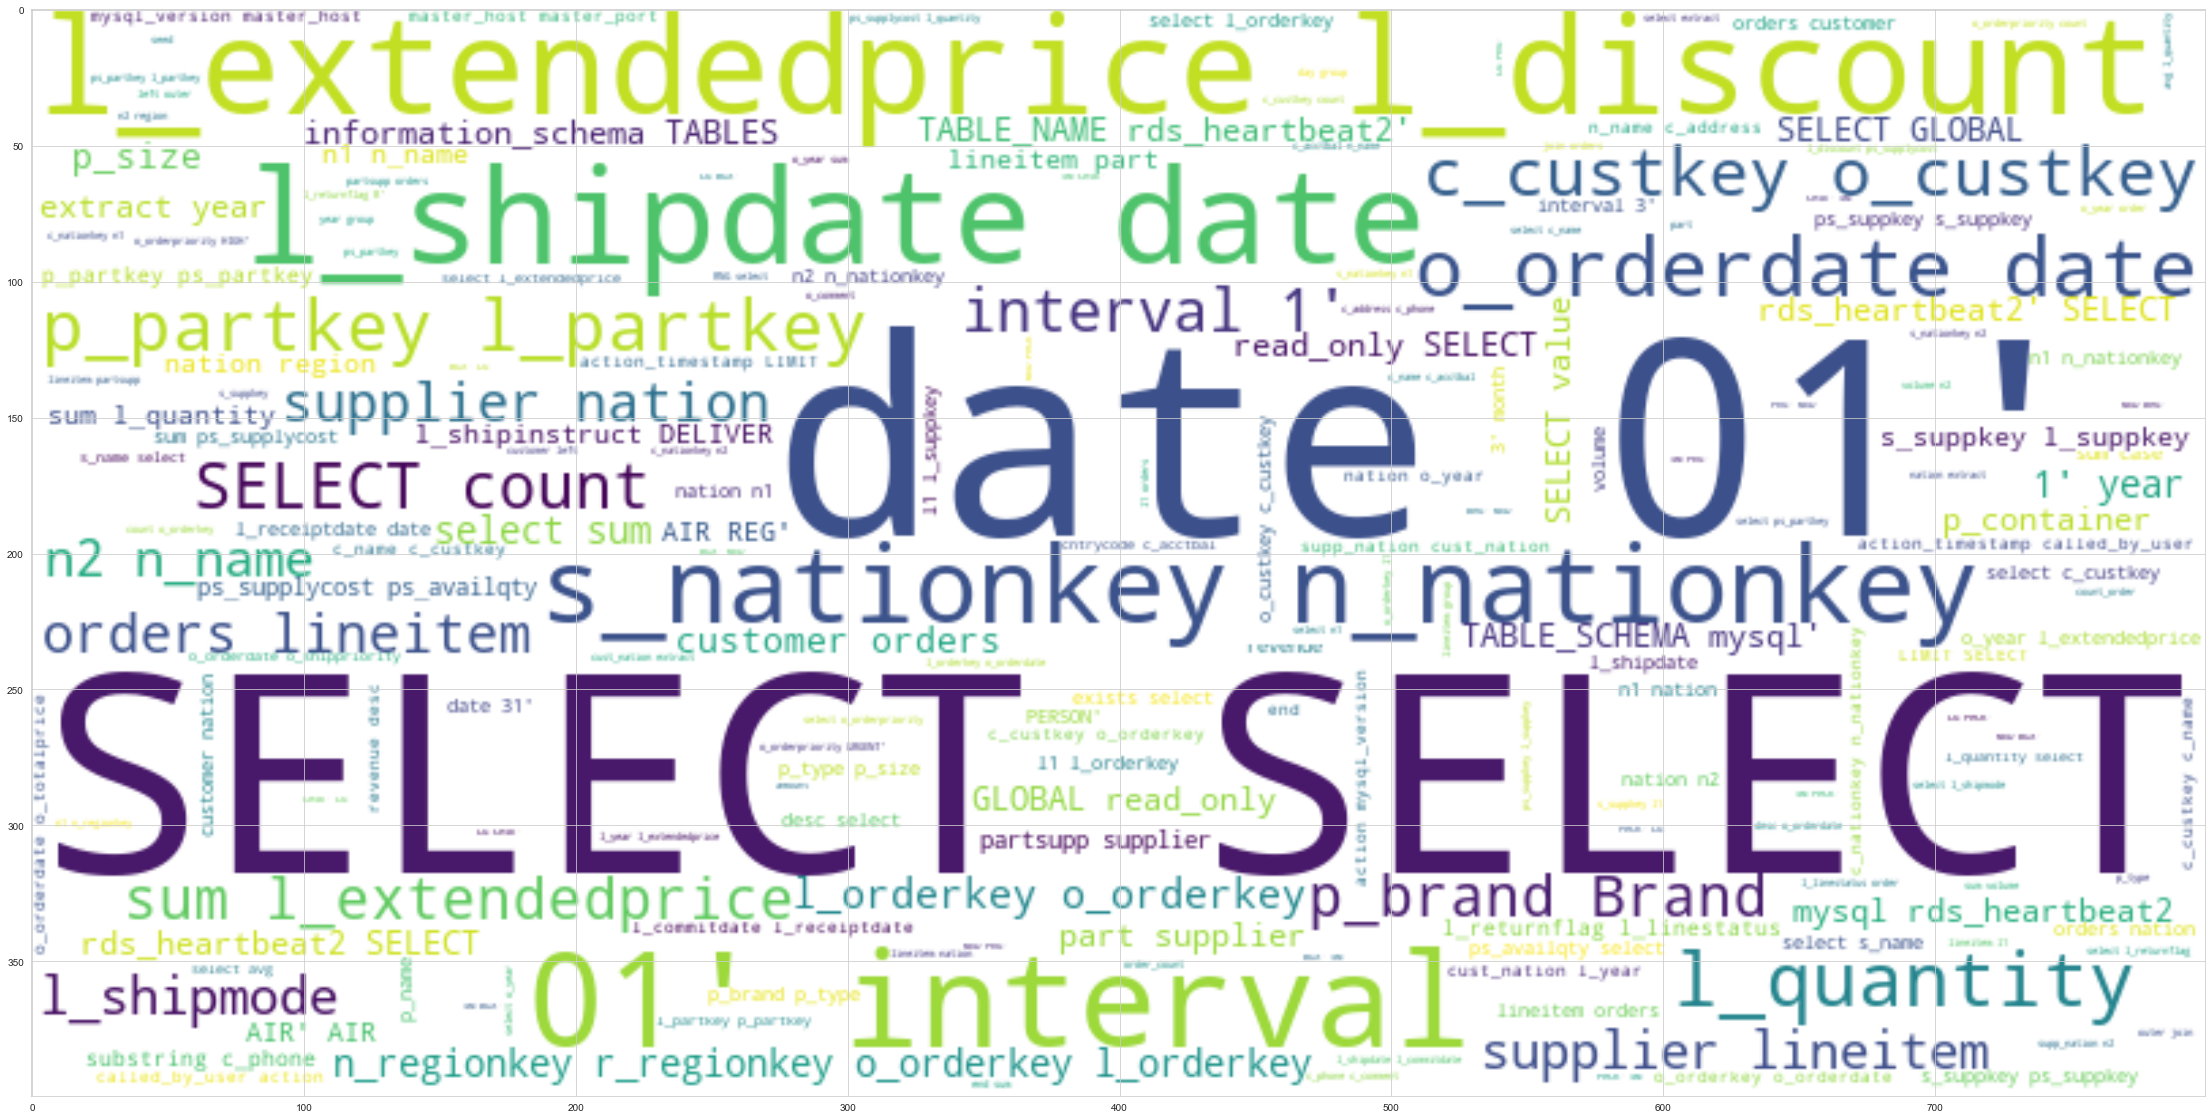

In [30]:
from wordcloud import WordCloud
text = " ".join(feedback for feedback in df_clean.sql_text_tokenized.astype(str))
print ("There are {} words in the combination of all cells in column sql_text.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud( background_color="white", width=800, height=400).generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

## Get top n words 

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['sql_text_tokenized'], 100)
df2 = pd.DataFrame(common_words, columns = ['SQLText' , 'count'])
#df2.head()
df2.groupby('SQLText').sum()['count'].sort_values(ascending=False)
df2.groupby('SQLText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 100 words in Clean SQL text')

### Vectorizing the sql_text column

There are various ways to vectorize a categorical feature. We will try three of them in this example. 

1- Frequency based encodings

In [32]:
# Count vectorization from sklearn 

vectorizer = CountVectorizer()
sql_transformed_1 = vectorizer.fit_transform(df_clean['sql_text_tokenized'])
sql_transformed_1 = sql_transformed_1.toarray()

2- Boolean vector encoding 

In [33]:
# One-hot encoding
from sklearn.preprocessing import Binarizer
freq   = CountVectorizer()
corpus = freq.fit_transform(df_clean['sql_text_tokenized'])
onehot = Binarizer()
sql_transformed_2 = onehot.fit_transform(corpus.toarray())

3- Term Frequency–Inverse Document Frequency

In [34]:
# TF–IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf  = TfidfVectorizer()
sql_transformed_3 = tfidf.fit_transform((df_clean['sql_text_tokenized'])).toarray()

In [35]:
Features = sql_transformed_2   # One can use other vectorized sql_texts but this one results in better results
Features.shape

(15688, 801)

### <font color="red"> Model: Linear regression with multiple variables 

In [36]:
# Numeric features 
Features = np.concatenate([Features, np.array(df_clean[['row_diff']])], axis = 1)   # We add row_diff as another feature to predict the query exectution time. 
labels = np.array(df_clean['query_time_milisec'])

### Split the dataset 

In [37]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
labels = np.array(df_clean['query_time_milisec'])
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 100) 
x_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

### Construct the linear regression model 

In [38]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

### Evaluate the model 

In [39]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score, 28)    

Mean Square Error      = 6015.51652674306
Root Mean Square Error = 77.55976100235908
Mean Absolute Error    = 35.04427009867247
Median Absolute Error  = 0.9237690617596581
R^2                    = 0.9956785735058827
Adjusted R^2           = 0.9940580385705887


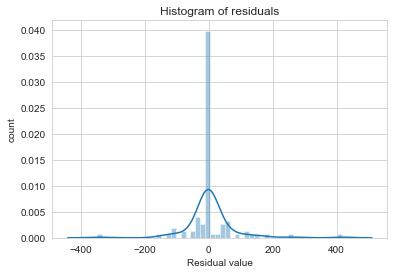

In [40]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)    

#### The residuals are not optimal but the distribution is Gaussian and with a left skew. 

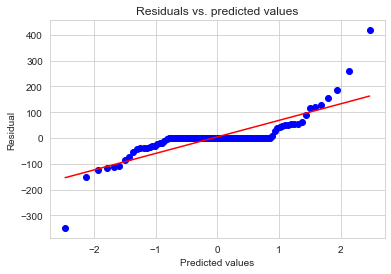

In [41]:
import scipy.stats as ss
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
 
    
resid_qq(y_test, y_score) 

#### The Q-Q Normal plot indicates the residuals are close to Normally distributed, show some skew (deviation from the straight line). This is particularly for large residuals. 

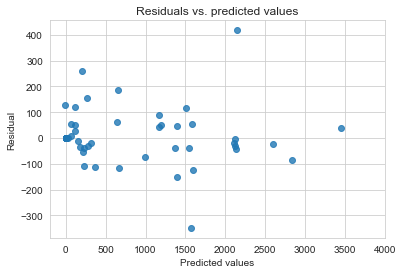

In [42]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.xlim(-200,4000)

resid_plot(y_test, y_score) 

#### The residual values appear to have a fairly constant dispersion as the predicted value changes. A few large residuals are noticeable.